In [1]:
%cd /content/drive/MyDrive/genai/Cycle_gan/MonetGAN

/content/drive/MyDrive/genai/Cycle_gan/MonetGAN


In [2]:
!pwd

/content/drive/MyDrive/genai/Cycle_gan/MonetGAN


In [3]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [4]:
class ResidualBlock(nn.Module):
  def __init__(self,in_channals):
    super(ResidualBlock,self).__init__()
    self.block=nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(in_channals,in_channals,3),
        nn.InstanceNorm2d(in_channals),
        nn.ReLU(inplace=True),
        nn.ReflectionPad2d(1),
        nn.Conv2d(in_channals,in_channals,3),
        nn.InstanceNorm2d(in_channals)
    )

  def forward(self,x):
    return x+self.block(x)

  #def forward(self,x):
    #return x+self.block(x)

In [5]:
class GeneratorResNet(nn.Module):
  def __init__(self, in_channels, num_residual_blocks=9):
      super(GeneratorResNet, self).__init__()

      # Inital Convolution 3*256*256 -> 64*256*256
      out_channels = 64
      self.conv = nn.Sequential(
          nn.ReflectionPad2d(in_channels),  # padding, keep the image size constant a
          nn.Conv2d(in_channels, out_channels, 2 * in_channels + 1),
          nn.InstanceNorm2d(out_channels),
          nn.ReLU(inplace=True),

      )

      channels = out_channels

      # 64*256*256-> 128*128*128 -> 256*64*64
      # Downsampling
      self.down = []
      for _ in range(2):
          out_channels = channels * 2
          self.down += [
              nn.Conv2d(channels, out_channels, 3, stride=2, padding=1),
              nn.InstanceNorm2d(out_channels),
              nn.ReLU(inplace=True),
          ]

          channels = out_channels
      self.down = nn.Sequential(*self.down)

      # Transformation (ResNet) 256*64*64
      self.trans = [ResidualBlock(channels) for _ in range(num_residual_blocks)]
      self.trans = nn.Sequential(*self.trans)

      # Upsampling 256*64*64-> 128*128*128-> 64*256*256
      self.up = []
      for _ in range(2):
          out_channels = channels // 2  # Fixed: out channels to out_channels and // for floor division
          self.up += [
              nn.Upsample(scale_factor=2),  # bilinear interpolation
              nn.Conv2d(channels, out_channels, 3, stride=1, padding=1),
              nn.InstanceNorm2d(out_channels),
              nn.ReLU(inplace=True),
          ]

          channels = out_channels
      self.up = nn.Sequential(*self.up)  # Fixed: Indentation

      # Out layer 64*256*256 -> 3*256*256
      self.out = nn.Sequential(
          nn.ReflectionPad2d(in_channels),
          nn.Conv2d(channels, in_channels, 2 * in_channels + 1),
          nn.Tanh()
      )

  def forward(self, x):
      x = self.conv(x)
      x = self.down(x)
      x = self.trans(x)
      x = self.up(x)
      x = self.out(x)
      return x

In [6]:
class Discriminator(nn.Module):
    def __init__(self, in_channels): # Corrected: __init__ instead of _init_
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # why normalize=False?
            *self.block(in_channels, 64, normalize=False),  # 3*256*256 -> 64*128*128
            *self.block(64, 128),  # 64*128*128-> 128*64*64
            *self.block(128, 256),  # 128*64*64 -> 256*32*32
            *self.block(256, 512),  # 256*32*32->512*16*16

            # Why padding first then convolution?
            nn.ZeroPad2d((1, 0, 1, 0)),  # padding left and top
            nn.Conv2d(512, 1, 4, padding=1)  # 512*17*17->1*16*16

            # 512*16*16 -> 512*17*17 # This comment seems to be describing the previous line's effect
            # I  # This line seems to be a typo and can be removed
        )

        self.scale_factor = 16

    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

        return layers

    def forward(self, x):
        return self.model(x)

In [7]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

In [8]:
G_AB = GeneratorResNet(3,num_residual_blocks=9)
D_B = Discriminator(3)
G_BA = GeneratorResNet(3,num_residual_blocks=9)
D_A = Discriminator(3)


In [9]:
cuda = torch.cuda.is_available()
if cuda:
    G_AB = G_AB.cuda()
    D_B = D_B.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()

    criterion_GAN = criterion_GAN.cuda()
    criterion_cycle = criterion_cycle.cuda()
    criterion_identity = criterion_identity.cuda()

In [10]:
import itertools
lr = 0.0002
b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2))

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1, b2))

optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1, b2))

In [11]:
n_epoches = 100
decay_epoch = 20

lambda_func = lambda epoch: 1 - max(0, epoch - decay_epoch) / (n_epoches - decay_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_func)  # Changed: Ir_scheduler to lr_scheduler
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_func)

In [12]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, data_dir, mode='train', transforms=None): # Fixed: Indentation and __init__
        A_dir = os.path.join(data_dir, 'monet_jpg')
        B_dir = os.path.join(data_dir, 'photo_jpg')

        if mode == 'train':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[:250]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[:250]]
        elif mode == 'test':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[250:]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[250:301]]

        self.transforms = transforms

    def __len__(self): # Fixed: Indentation and __len__
        return len(self.files_A)

    def __getitem__(self, index): # Fixed: Indentation and __getitem__
        file_A = self.files_A[index]
        file_B = self.files_B[index]

        img_A = Image.open(file_A)
        img_B = Image.open(file_B)

        if self.transforms is not None:
            img_A = self.transforms(img_A)
            img_B = self.transforms(img_B)

        return img_A, img_B

In [13]:
!pwd

/content/drive/MyDrive/genai/Cycle_gan/MonetGAN


In [14]:
!git clone https://github.com/ym59/MonetGAN.git

Cloning into 'MonetGAN'...
remote: Enumerating objects: 14375, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 14375 (delta 0), reused 1 (delta 0), pack-reused 14372 (from 1)
Receiving objects: 100% (14375/14375), 213.56 MiB | 12.24 MiB/s, done.
You can inspect what was checked out with 'git status'
and retry with 'git restore --source=HEAD :/'

^C


In [15]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader # import DataLoader
from PIL import Image # Import Image from PIL
import os

class ImageDataset(Dataset): # ImageDataset class definition
    def __init__(self, data_dir, mode='train', transforms=None): # Corrected: Indentation and __init__
        # Removed the "dataset" subfolder from the paths:
        A_dir = os.path.join(data_dir, 'monet_jpg')
        B_dir = os.path.join(data_dir, 'photo_jpg')

        if mode == 'train':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[:250]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[:250]]
        elif mode == 'test':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[250:]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[250:301]]

        self.transforms = transforms

    def __len__(self): # Corrected: Indentation and __len__
        return len(self.files_A)

    def __getitem__(self, index): # Corrected: Indentation and __getitem__
        file_A = self.files_A[index]
        file_B = self.files_B[index]

        img_A = Image.open(file_A)
        img_B = Image.open(file_B)

        if self.transforms is not None:
            img_A = self.transforms(img_A)
            img_B = self.transforms(img_B)

        return img_A, img_B

data_dir = "/content/drive/MyDrive/genai/Cycle_gan/MonetGAN"

transforms_ = transforms.Compose([ # Corrected: transforms_
    # transforms.Resize(int(256*1.12), Image.BICUBIC),
    #transforms.RandomCrop(256, 256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 5

trainloader = DataLoader(
    ImageDataset(data_dir, mode='train', transforms=transforms_), # Corrected: Indentation
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
testloader = DataLoader(
    ImageDataset(data_dir, mode='test', transforms=transforms_), # Corrected: Indentation
    batch_size=batch_size,
    shuffle=False,
    num_workers=3
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [16]:
import torch

# Check CUDA availability and assign to cuda variable
cuda = torch.cuda.is_available()
from torchvision.utils import make_grid

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

def sample_images(real_A, real_B, figside=1.5):
    assert real_A.size() == real_B.size(), 'The image size for two domains must be the same'

    G_AB.eval()
    G_BA.eval()

    real_A = real_A.type(Tensor)
    fake_B = G_AB(real_A).detach()
    real_B = real_B.type(Tensor)
    fake_A = G_BA(real_B).detach()

    nrows = real_A.size(0)
    real_A = make_grid(real_A, nrow=nrows, normalize=True)
    fake_B = make_grid(fake_B, nrow=nrows, normalize=True)
    real_B = make_grid(real_B, nrow=nrows, normalize=True)
    fake_A = make_grid(fake_A, nrow=nrows, normalize=True)

    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1).cpu().permute(1, 2, 0)

    plt.figure(figsize=(figside * nrows, figside * 4))
    plt.imshow(image_grid)
    plt.axis('off')
    plt.show()

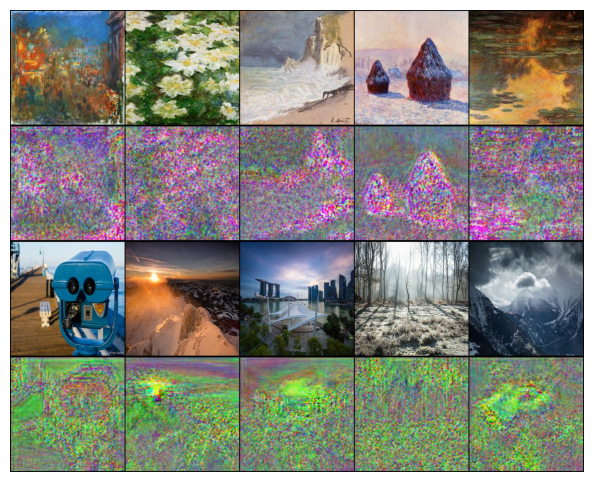

In [17]:
real_A, real_B = next(iter(testloader))
sample_images(real_A, real_B)

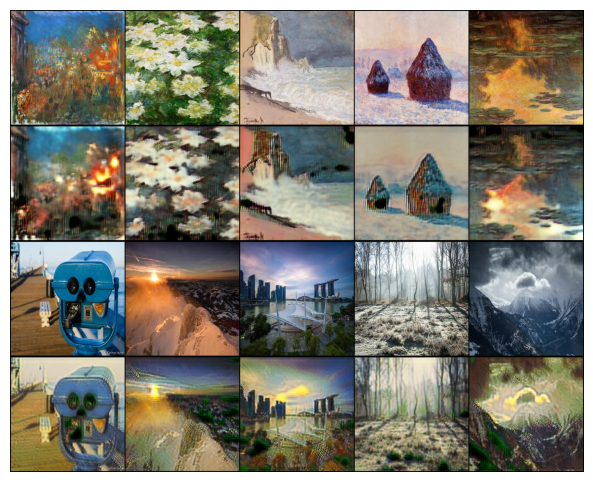

[Epoch 10/100]
[G loss: 3.525991916656494 | identity: 0.20977073907852173 GAN: 0.4091017246246338 cycle: 0.20680364966392517]
[D loss: 0.18390195071697235 | D_A: 0.18555769324302673 D_B: 0.18224620819091797 ]


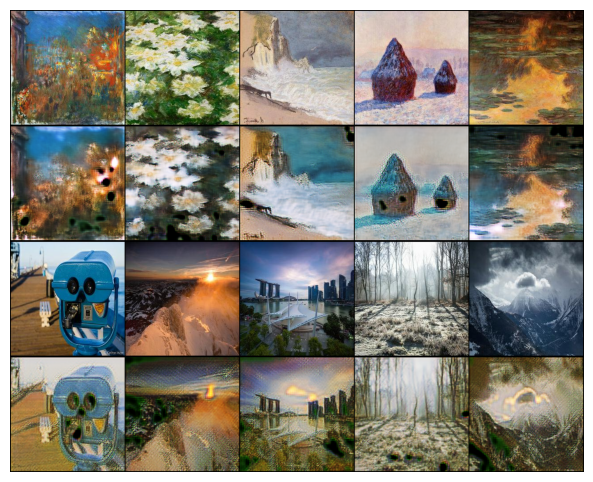

[Epoch 20/100]
[G loss: 3.47178316116333 | identity: 0.2040747106075287 GAN: 0.5885540843009949 cycle: 0.18628555536270142]
[D loss: 0.10181527584791183 | D_A: 0.13814590871334076 D_B: 0.06548464298248291 ]


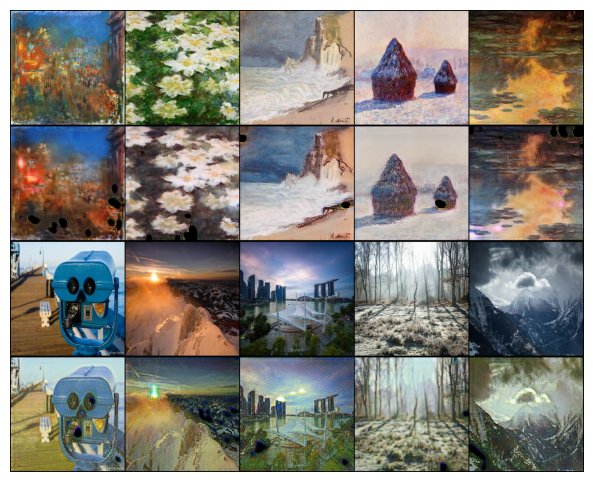

[Epoch 30/100]
[G loss: 3.425629138946533 | identity: 0.21090325713157654 GAN: 0.5058812499046326 cycle: 0.18652313947677612]
[D loss: 0.139447420835495 | D_A: 0.17431232333183289 D_B: 0.10458251088857651 ]


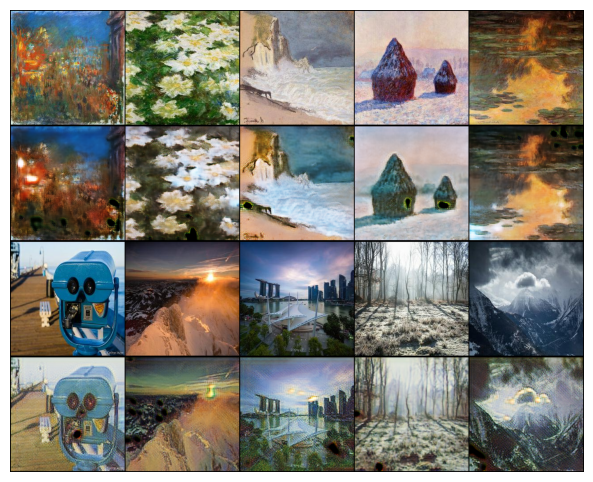

[Epoch 40/100]
[G loss: 3.2024106979370117 | identity: 0.18143486976623535 GAN: 0.5135759711265564 cycle: 0.17816601693630219]
[D loss: 0.1561254858970642 | D_A: 0.06919759511947632 D_B: 0.2430533766746521 ]


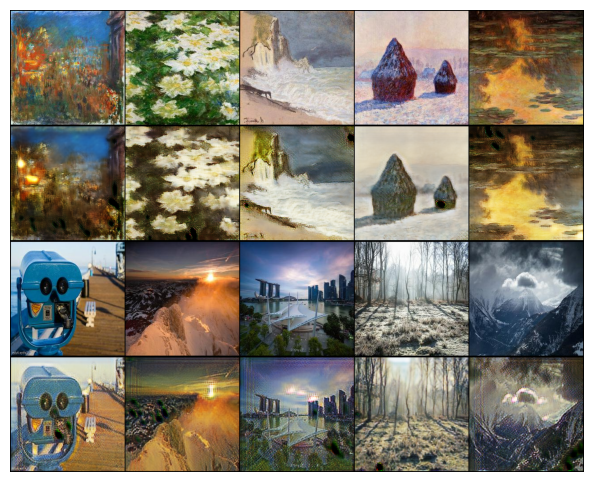

[Epoch 50/100]
[G loss: 2.820469379425049 | identity: 0.16082486510276794 GAN: 0.6011070013046265 cycle: 0.1415238082408905]
[D loss: 0.10985918343067169 | D_A: 0.12880899012088776 D_B: 0.09090936928987503 ]


In [ ]:
for epoch in range(n_epoches):
    for i, (real_A, real_B) in enumerate(trainloader):
        real_A, real_B = real_A.type(Tensor), real_B.type(Tensor)

        # groud truth
        out_shape =[real_A.size(0),1, real_A.size(2)//D_A.scale_factor, real_A.size(3)//D_A.scale_factor]
        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)

        """Train Generators"""
        # set to training mode in the begining, beacause sample_images will set it to eval mode
        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()

        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        # identity loss
        loss_id_A = criterion_identity(fake_B, real_A)
        loss_id_B = criterion_identity(fake_A, real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN loss, train G to make D think it's true
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # cycle loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2


        loss_G = 5.0*loss_identity + loss_GAN + 10.0*loss_cycle

        loss_G.backward()
        optimizer_G.step()

        """Train Discriminator A"""
        optimizer_D_A.zero_grad()

        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A= (loss_real + loss_fake) / 2

        loss_D_A.backward()
        optimizer_D_A.step()

        """Train Discriminator B"""
        optimizer_D_B.zero_grad()

        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2

        loss_D_B.backward()
        optimizer_D_B.step()

    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # test
    if (epoch+1) % 10 == 0:
        test_real_A, test_real_B = next(iter(testloader))
        sample_images(test_real_A, test_real_B)
        loss_D = (loss_D_A + loss_D_B) / 2
        print(f'[Epoch {epoch+1}/{n_epoches}]')
        print(f'[G loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
        print(f'[D loss: {loss_D.item()} | D_A: {loss_D_A.item()} D_B: {loss_D_B.item() } ]')